In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import plot_ellipse, moca, dopioe, espra, smooth, tilt_distance_LI, robust_smooth

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)


### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}


theta_mean, phi_mean = np.float64(154.2824649730562), np.float64(-37.90695441792832)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


(np.float64(-502049.6066115854),
 np.float64(364992.95340685744),
 np.float64(-498728.05960995663),
 np.float64(478071.94039004337))

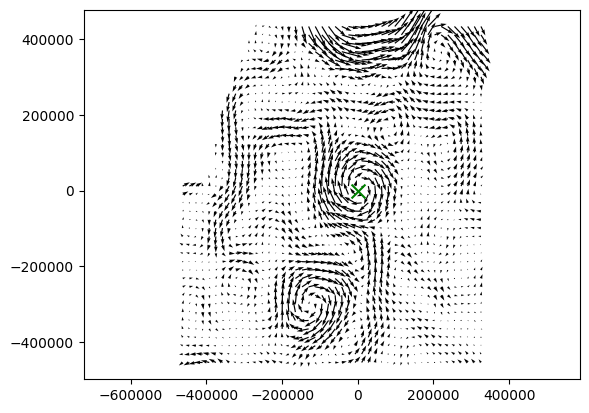

In [3]:
t_idx = 0
dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
ut, vt = dic['u'], dic['v']
plt.quiver(x_ssh, y_ssh, ut, vt)
plt.scatter(0,0, marker='x', color='g', s=100)
plt.axis('equal')


In [4]:
def dopioe_pipeliner(nxc, nyc, cyc, ut, vt, X_new, Y_new, r=30000):

    R_grid = np.hypot(nxc - X_new, nyc - Y_new)
    ic, jc = map(int, np.unravel_index(np.argmin(R_grid), R_grid.shape))

    # DOPIOE wont work if too close to boundary
    x_new = X_new[:, 0]
    y_new = Y_new[0, :]

    # horizontal transect (constant y = y[jc])
    x_mask = np.abs(x_new - nxc) <= r
    x1 = x_new[x_mask]
    y1 = np.full_like(x1, y_new[jc])
    u1 = ut[x_mask, jc]
    v1 = vt[x_mask, jc]
    
    # vertical transect (constant x = x[ic])
    y_mask = np.abs(y_new - nyc) <= r
    y2 = y_new[y_mask]
    x2 = np.full_like(y2, x_new[ic])
    u2 = ut[ic, y_mask]
    v2 = vt[ic, y_mask]
    
    xc, yc, w, Q, Rc, psi0, A = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, A_flag=True, plot_flag=False)
    
    cyc_DOPIOE = 'CE' if w < 0 else 'AE'
    
    if (cyc_DOPIOE != cyc) or (np.hypot(nxc - xc, nyc - yc) > 50000):
        return np.nan, np.nan, np.nan, np.array([[np.nan, np.nan],
                                                [np.nan, np.nan]]), np.nan, np.nan
    
    return xc, yc, w, Q, Rc, psi0, A


In [5]:
xc_pre, yc_pre = 0, 0
df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Time'])
for t_idx in range(len(dic_ssh_data)):
    dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
    ut, vt = dic['u'], dic['v']
    xc, yc, w, Q, Rc, psi0, A = dopioe_pipeliner(xc_pre, yc_pre, 'CE', ut.T, vt.T, x_ssh.T, y_ssh.T, r=60000)
    df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q,
                               'Rc': Rc, 'psi0': psi0, 'A': A, 'Time': list(dic_ssh_data.keys())[t_idx]}
    if np.isnan(xc):
        break
    xc_pre, yc_pre = xc, yc
df_res


,xc,yc,w,Q,Rc,psi0,A,Time
0,7778.250591,5194.366671,-0.000032,"[[1.1597743251236283, 0.04072536024881763], [0...",105690.531592,87561.546112,-0.000008,2023-10-18 18:00:00
1,5278.747976,5545.626410,-0.000033,"[[1.2270866608874156, 0.01358879086488076], [0...",74791.550688,45461.898106,-0.000008,2023-10-19 18:00:00
2,5876.765861,4692.686847,-0.000036,"[[1.2209066862803593, 0.040692083903669754], [...",75398.756793,49736.319732,-0.000009,2023-10-20 18:00:00
3,4358.976343,6179.074482,-0.000034,"[[1.209560248911314, -0.003148760656265268], [...",72891.240691,44780.240219,-0.000008,2023-10-21 18:00:00
4,3464.468478,6397.707243,-0.000033,"[[1.2136848055901446, 0.02091077411728526], [0...",65743.966387,34559.815593,-0.000008,2023-10-22 18:00:00
...,...,...,...,...,...,...,...,...
116,-320523.023536,84938.607828,-0.000018,"[[1.4783300073950387, -0.11150921391283827], [...",58147.197117,14324.291840,-0.000004,2024-02-07 06:00:00
117,-316959.601588,81287.543474,-0.000018,"[[1.4562070540288674, -0.15441877106114502], [...",50928.468369,10844.560151,-0.000004,2024-02-08 06:00:00
118,-316692.475585,79248.309003,-0.000018,"[[1.5080438780030343, -0.152726370805029], [-0...",81296.515131,27169.012127,-0.000004,2024-02-09 06:00:00
119,-314454.288204,79455.561013,-0.000017,"[[1.5996813661250602, -0.15023868005957658], [...",79753.840842,24756.249534,-0.000004,2024-02-10 06:00:00


(np.float64(-340924.3518053257),
 np.float64(24383.13641988145),
 np.float64(-9217.752910881107),
 np.float64(167064.04540897527))

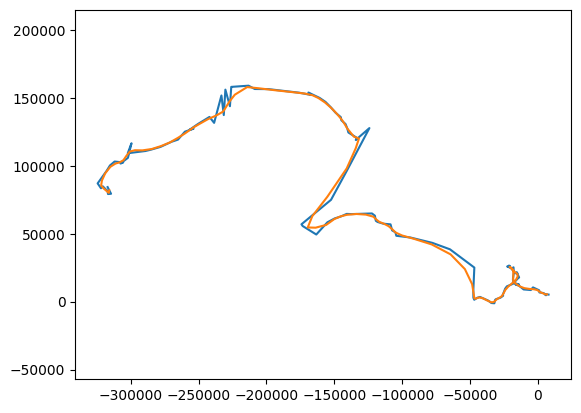

In [6]:
wdw = 3
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)
plt.axis('equal')


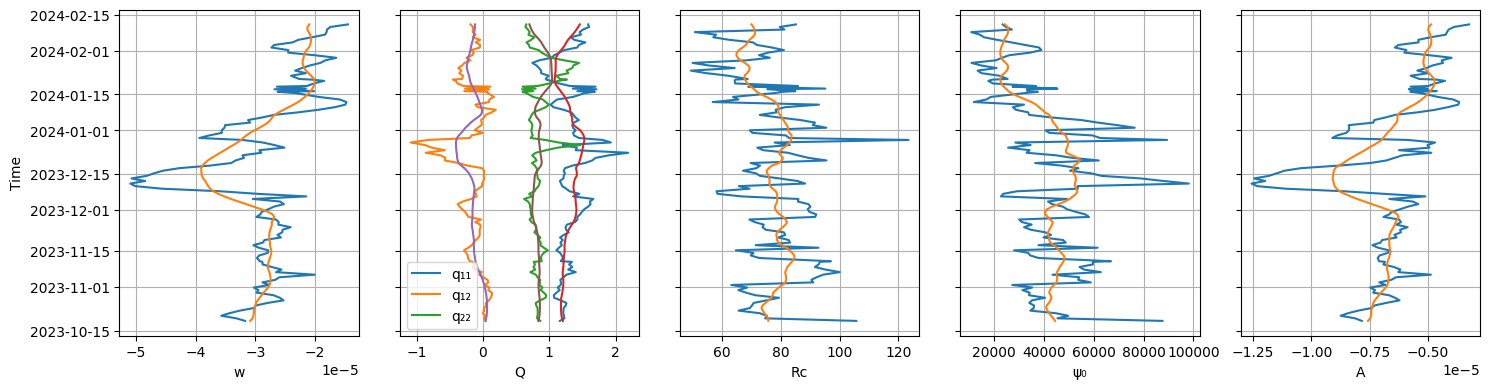

In [7]:
wdw = 20
df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Time, window=wdw, num=len(df_res)) 

fig, axs = plt.subplots(1, 5, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Time)
axs[0].plot(df_res.sw, df_res.Time)
axs[0].set_xlabel('w')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1000, df_res.Time)
axs[2].plot(df_res.sRc/1000, df_res.Time)
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Time)
axs[3].plot(df_res.spsi0, df_res.Time)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Time)
axs[4].plot(df_res.sA, df_res.Time)
axs[4].set_xlabel('A')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


Text(0.5, 1.0, '2023-11-07 18:00:00')

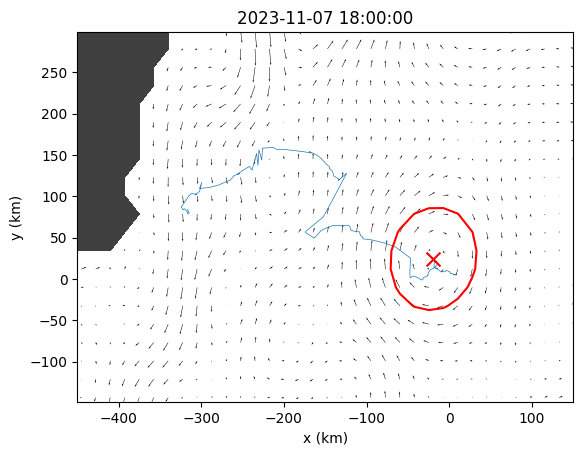

In [10]:
t_idx = 20

dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
ut, vt = dic['u'], dic['v']
plt.quiver(x_ssh/1e3, y_ssh/1e3, ut, vt, width=.001, scale=30)
plt.plot(df_res.xc/1e3, df_res.yc/1e3, lw=.5)
data = df_res.iloc[t_idx]
plt.scatter(data.xc/1e3, data.yc/1e3, marker='x', color='r', s=100, zorder=3)

dx_ell, dy_ell = x_ssh/1e3 - data.xc/1e3, y_ssh/1e3 - data.yc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
plt.contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2],
            colors='r', zorder=3)

land_mask = np.zeros_like(ut)
land_mask = np.where(np.isnan(ut), 0, np.nan)
plt.contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')

plt.xlabel('x (km)'); plt.ylabel('y (km)')
plt.axis('equal')
plt.xlim(-450, 150); plt.ylim(-100, 250)
plt.title(f'{list(dic_ssh_data.keys())[t_idx]}')



In [11]:
## MOVIE
# for t_idx in range(len(dic_ssh_data)):
#     dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
#     ut, vt = dic['u'], dic['v']
#     plt.quiver(x_ssh/1e3, y_ssh/1e3, ut, vt, width=.001, scale=30)
#     plt.plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5)
#     data = df_res.iloc[t_idx]
#     plt.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=100, zorder=3)
    
#     dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
#     rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
#     plt.contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2],
#                 colors='r', zorder=3)
    
#     land_mask = np.zeros_like(ut)
#     land_mask = np.where(np.isnan(ut), 0, np.nan)
#     plt.contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')
    
#     plt.xlabel('x (km)'); plt.ylabel('y (km)')
#     plt.axis('equal')
#     plt.xlim(-450, 150); plt.ylim(-100, 250)
#     plt.title(f'{list(dic_ssh_data.keys())[t_idx]}')
        
#     plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/DOPIOE_IMOS_Data/tracking_images/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#     plt.close()
    